# Los Angeles Homelessness By Land Use

An exploration of the Los Angeles homelessness counts allocated to land use categories.

The Los Angeles Homeless Services Authority is responsible for conducting the annual Point-In-Time-Count of homeless people in Los Angeles, and publishes the data to their website. The dataqset they publish dataset is re-packaged for easier analysis at the [San Diego Regional Data Library's Data Repository. ](https://data.sandiegodata.org/dataset/lahsa-org-homeless_count-2018-los_angeles). This analysis links the Data Library's data package to LA City tax assessor's parcels to study estimates of homless populations organized by land use categories. 


In [1]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack 
!{sys.executable} -mpip -q install contextily rtree descartes

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
sns.set(color_codes=True)


In [2]:

def add_lu_codes(df):
    """"The LU codes don't survive groupby"""
    return df.merge(plan_codes.rename(columns={'scag_gp_co':'code_name'}), on='code')

def barchart(df, title,  x_col, x_lab, y_col, y_lab, n=5):

    df = df.sort_values(y_col, ascending=False).head(n)
    
    plt.figure(figsize=(8,6))

    ax = sns.barplot(x=x_col, y=y_col, data=df)

    plt.xticks(rotation=30);

    ax.set_title(title, fontsize=16);
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)

In [3]:

#pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-la_parcels-2.zip')
pkg = mp.open_package('index:sandiegodata.org-la_parcels-2')
plan_codes = pkg.resource('la-planning-code').dataframe()
tractparcels = pkg.resource('tract_to_parcels').geoframe()


In [4]:
pitc_pkg = mp.open_package('http://library.metatab.org/lahsa.org-homeless_count-2018-los_angeles-1.zip')
pitc_tracts = pitc_pkg.resource('tracts').dataframe().rename(columns={'tract':'geoid'})

tracts = rg.geoframe('census://2016/1/CA/tract').rename(columns={'tract':'geoid'})

In [5]:
##
## pitc_tracts_count and pitc_tracts_den. counts and densities per tract,
##

# Add up acres per parcel per tract to get areas of the tract. This will 
# be less than whole area of the tract, but should be proportional to the actual area. 
tp = tractparcels.groupby(['geoid','code']).sum().acres.to_frame().reset_index()

# Link tracts to communities
tract_communities = pitc_tracts[['geoid','community_name']]

# Calculate PITC tract counts expressed as density, people per acre
tot_cols = ['totvanpeople','totcamperpeople','tottentpeople','totmakeshiftpeople','totunsheltpeople']
den_cols = [ c+'_den' for c in tot_cols ]

t = pitc_tracts.merge(tracts,on='geoid') # Link to Census tract information

t=t[['geoid', 'aland']+tot_cols]

t['tract_acres'] = t.aland/4046.86 #  Convert to acres: 4047 sq m per acre

pitc_tracts_count = t.copy()

t.loc[:,tot_cols] = t.loc[:,tot_cols].div(t.tract_acres, axis=0) # Div each count in subset by acres to get density 

pitc_tracts_den = t

    

In [6]:
##
## tract_code. One row per tract-land-use code with counts and densities of each of the
## homelessness categories
## 

# Per-tract counts merged with census tract info
t = tracts[['geoid','geometry']].merge( pitc_tracts_count, on='geoid')
t = t[['geoid', 'tract_acres'] + tot_cols ] 

# Area of all parcels per tract
tp = tractparcels.groupby(['geoid','code']).sum().acres.to_frame().reset_index()

t = t.merge(tp, on='geoid') # Merge land use groups per tract to tracts

x = t

#Compute the area of the tract from the sum of the land-use categories per tract
tot_acres_per_geoid = t.groupby('geoid').acres.sum().to_frame().rename(columns={'acres':'tract_acres_parcel'})

# Add to each tract/landuse row the total area for the tract
t = t.merge(tot_acres_per_geoid, on='geoid')

# Divide the two to get the portion of each tract in each land use category
t['tract_portion'] = t.acres / t.tract_acres_parcel

for c in tot_cols:
    t[c] = t[c] * t.tract_portion



tract_code_counts = t.copy()

tract_code_den = t.copy()

# Compute densities
for c in tot_cols:
    tract_code_den[c] = tract_code_den[c] * t.tract_portion
    tract_code_den.rename(columns={c:c+'_den'}, inplace=True)


tract_code_den = tract_code_den.drop(['acres', 'tract_acres_parcel', 'tract_acres','tract_portion'], axis=1) 

tract_code = tract_code_counts.merge(tract_code_den, on=['geoid','code'])
    
# acres: area of the landuse code areas within the tract
# tract_acres_parcel: sum of the areas of all of the parcels in the tract
# tract_acres: Area calculated for the hole tract, which is more than tract_acres_parcel
tract_code = tract_code[['geoid', 'code','acres', 'tract_acres_parcel', 'tract_acres', 'tract_portion']
                         + tot_cols + den_cols ]

tract_code = tract_code.merge(plan_codes, on='code').rename(columns={'scag_gp_co': 'code_name'})


In [7]:
##
## by_codes. Re-aggregate tract-codes to just the codes. 
## 
agg_map = {
    'code_name' : 'first',
    'acres' : 'sum'
 
}

agg_map.update({c:'sum' for c in tot_cols})

t = tract_code.groupby('code').agg(agg_map).copy()

for c in tot_cols:
    t[c+'_den'] = t[c] / t['acres']

by_codes = t
 

# High Density Homelessness

The PITC records counts for 2159 census tracts in Los Angeles county, but most have reatively few homeless.  This map shows the top 50 tracts with the higest density of homeless. The yellow tract is Skid Row, the highest homeless density neighborhood in the state. Other tracts are Downtown, Venice, Stanta Monica, Van Nuys and other high density neighborhoods. 

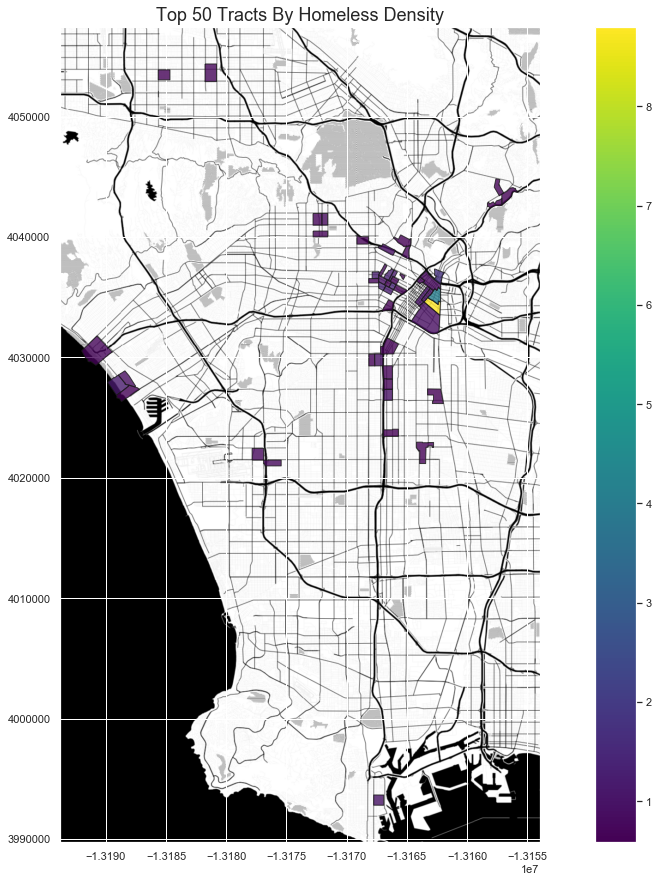

In [8]:
#
# Map of the top 50 tracts for total number of unsheletered

# Add a basemap, as per the Geopandas documentation. 
def add_basemap(ax, zoom=10, url=ctx.sources.ST_TONER_BACKGROUND):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
def plot_with_basemap(df, column=None, title='', cmap='tab10', zoom=10):
    
    
    # The web tiles are in epsg=3857, so we have to transform our map
    ax = df.to_crs(epsg=3857).plot(column=column, figsize=(20, 15), alpha=0.8,
                                   edgecolor='k', cmap=cmap, legend=True)
    add_basemap(ax, zoom=zoom )
    
    ax.set_title(title, fontsize=18);
    
t = tracts[['geoid', 'geometry']].set_index('geoid')\
    .join(pitc_tracts_den[['geoid','totunsheltpeople']].set_index('geoid'), how='right')

t = t.sort_values('totunsheltpeople', ascending=False).head(50)

top_50_unsheltered = t

plot_with_basemap(t, 'totunsheltpeople' , 'Top 50 Tracts By Homeless Density', zoom=12, cmap='viridis')


Homelessness is very concentrated; most of the homelss are in a small number of neighborhoods, although there are some variations in the distributions by the category of homelessness. The distributions for makeshift shelters and tents is narrower than that of the total unsheltered, meaning that people in structures and tents are more clustered togehter than those without stuctures or tents. This analysis will primarily use the total count of homeless, so note that for other categories, the distributions will be different. 

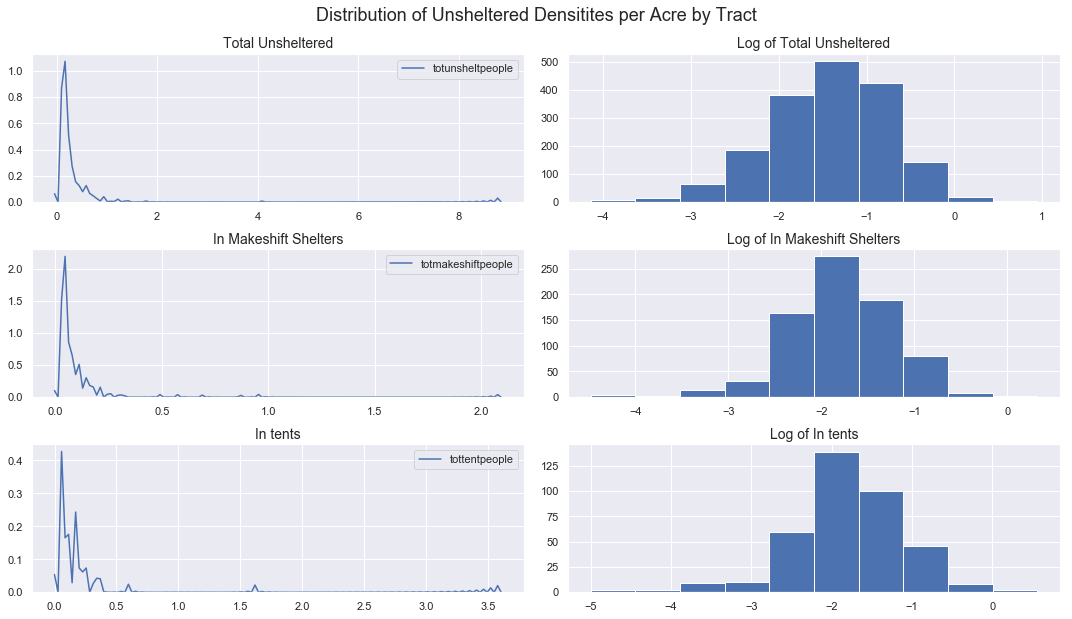

In [9]:
col = 'totunsheltpeople'
fig, axes = plt.subplots(3, 2, sharex=False, sharey=False, figsize=(15,9))
axes = axes.ravel()

def density_dist(df, col, axes, pos, title):
    # Distribution of densities below 75% percentile
    #q_75 = df[col].describe().at['75%']
    #df[df[col] < q_75][col].hist(ax=axes[pos])
    #df[col].hist(ax=axes[pos])
    
    sns.kdeplot(df[col], ax=axes[pos])
    axes[pos].set_title(title, fontsize=14);

    np.log10(df[df[col]> 0][col]).hist(ax=axes[pos+1])
    axes[pos+1].set_title('Log of '+title, fontsize=14);

density_dist(pitc_tracts_den, 'totunsheltpeople', axes, 0, 'Total Unsheltered')
density_dist(pitc_tracts_den, 'totmakeshiftpeople', axes, 2, 'In Makeshift Shelters')
density_dist(pitc_tracts_den, 'tottentpeople', axes, 4, 'In tents')

fig.suptitle('Distribution of Unsheltered Densitites per Acre by Tract', fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    
    

The PITC ( point in time count ) in Los Angeles categorizes homeless as individuals or part of families, makes estimates of age, and records what kind of shelter the person or group may have, including cars, vans, campers, tents, makeshift structures, or offical, established shelters. For these counts, "Unsheltered" means the person is living in a place that is not meant for human habitation, which includes cars, campters, tents, RV and makeshift structures, although the counts for the number pf people living in enclosed spaces is usually an estimate. HUD [publishes a guide for counting the homeless](https://www.hudexchange.info/onecpd/assets/File/Guide-for-Counting-Unsheltered-Homeless-Persons.pdf) that explains the terms in more detail. 

Most of the people counted in the LA homeless count are counted outside enclosed spaces, not in campers, vans, tents or structures -- the 'total' count is much larger than the categories for enclosed spaces.  


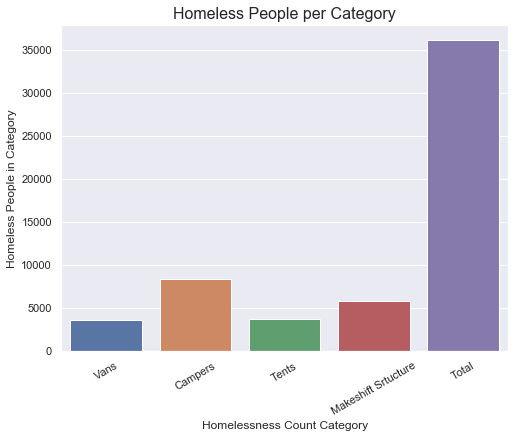

In [10]:
t = by_codes[tot_cols].stack().to_frame().reset_index()
t.columns = ['code','measure','value']

plt.figure(figsize=(8,6))
ax = sns.barplot(x="measure", y="value", data=t, ci=None, estimator=np.sum)
plt.xticks(rotation=30);

ax.set_title("Homeless People per Category", fontsize=16);
ax.set_xlabel('Homelessness Count Category')
ax.set_ylabel('Homeless People in Category');
plt.xticks(np.arange(5), ('Vans', 'Campers', 'Tents', 'Makeshift Srtucture', 'Total'));
    

# Homelessness by Land Use

The LA PITC publishes homeless counts by census tract, not point locations, so homeless locations can't be directly linked to specific parcels. Instead, his analysis allocates homeless in a tract proportionally to the parcels in the tract. So, if a tract is 50% single-family residential, 50% of the homeless in the tract are assigned to the single-family residential portion of that tract. 


It's commonly assumed that the homeless cluster in industrial or commercial areas, such as downtowns, but the largest number of homeless is actually in residential areas. The homeless are not paricularly concentrated in residential areas, but rather, residential areas are the most common land use. Excluding military bases, state parks, peserves, single and multi-family residential areas are about 38% percent of the lands use in the Los Angeles homelessness count area, and 74% of the land use in the City of Los Angeles. 


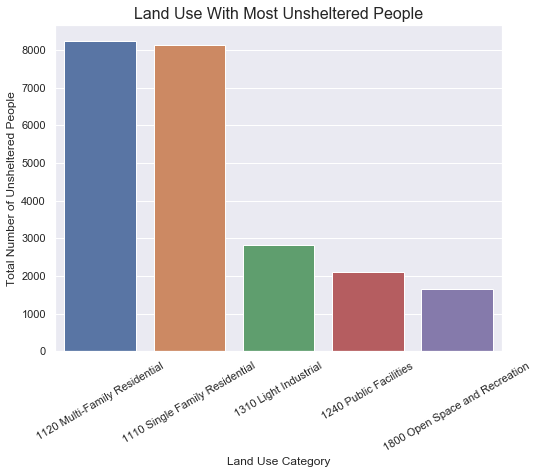

In [11]:
barchart( by_codes, 
         'Land Use With Most Unsheltered People',
         "code_name",'Land Use Category',
         "totunsheltpeople", "Total Number of Unsheltered People")

Here is the full table of the areas of the top land use codes, in percentage of all parcel area, in the City of Los Angeles, excluding regional parks, military bases, preserves and other open space ( excluded codes:  1830, 1860, 1800, 1270, 1850, 1880)

In [12]:
t = tractparcels[tractparcels.city == 'Los Angeles'][['code','acres']]

t = t[~t.code.isin([1830,1860,1800,1270,1850,1880])]

total = t.sum().acres 
t = t.groupby('code').sum()
t['acres'] = t.acres/total * 100 
t = t.sort_values('acres',ascending=False).join(plan_codes.set_index('code'))
t.columns = ['Area (Acres)','Land Use Code']
t.head(10)

,Area (Acres),Land Use Code
code,,
1110,56.777506,1110 Single Family Residential
1120,17.122042,1120 Multi-Family Residential
1240,5.742725,1240 Public Facilities
1310,4.158022,1310 Light Industrial
1410,3.487405,1410 Transportation
1220,2.640562,1220 Retail and Commercial and Services
1311,2.567764,1311 Light Manufacturing
1200,2.366987,1200 General Commercial
1321,2.208865,1321 Heavy Manufacturing


Although the largest number of homeless are counted in residential areas, they are very spread out, so the density in residential areas is relatively lower. The highest density areas are regional shopping areas, and, oddly, heavy manufacturing. 

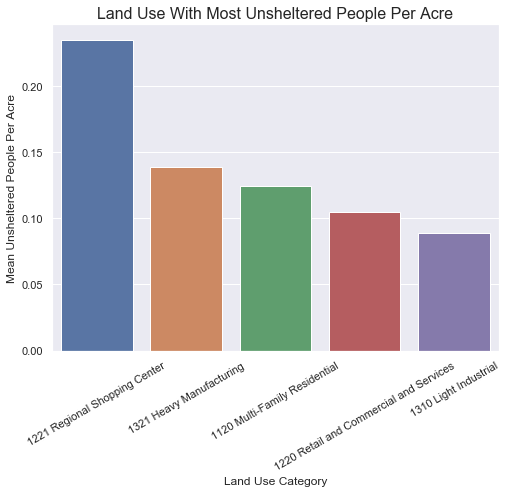

In [13]:
barchart(by_codes,
         'Land Use With Most Unsheltered People Per Acre',
         "code_name",'Land Use Category',
         "totunsheltpeople_den", "Mean Unsheltered People Per Acre")





However, the association between shopping areas and industrial areas and homeless may not be a direct realtionship, but rather based on the location of Skid Row, which is near the highest concentration of parcels marked as regional shopping in the county -- the Financial District, historic Downtown, Little Tokyo, Little China and Wilshire.

This map overlays the center points of parcels on the map of the top 50 highest homeless density tracts ( colored areas). The parcel points are colored by parcel type:

* Green: 1221 Regional Shopping Center
* Blue: 1321 Heavy Manufacturing
* Red: 1310 Light Industrial


Note that there are many places where tracts are in the top 50 that have a high shopping density and low homeless density, or a high homelss density and low shopping density. The yellow tract is the southern portion of Skid Row. Skid Rows doesn't have the high-density land use types in it, but 

[![Homelessness-land-use-top-50.png](http://insights.civicknowledge.com/wp-content/uploads/sites/15/2019/01/Homelessness-land-use-top-50.png)](https://i2.wp.com/insights.civicknowledge.com/wp-content/uploads/sites/15/2019/01/Homelessness-land-use-top-50.png?ssl=1)

(Click to expand the image)

Here is a similar map, but for each of the land use types, the tract that contains it is colored by the density of homeless in that tract. Note that the highest densities of homeless ( darker region color ) appears to correlate with higher parcel density ( closer dots of the same color. ) 

[![Homelessness-land-use.png](http://insights.civicknowledge.com/wp-content/uploads/sites/15/2019/01/Homelessness-land-use-2.png)](https://i2.wp.com/insights.civicknowledge.com/wp-content/uploads/sites/15/2019/01/Homelessness-land-use-2.png?ssl=1)


(Click to expand the image)


# Homeless By Community

As can be seen in the preceeding maps, the largest number of homeless are in the Skid Row and Downtown Los Angeles areas. Surprisingly, the third largest popultion is in Antelope Valley, the area of Lancaster and Palmdale, north of the San Gabriel mountains. 

In [14]:
pitc_tracts.groupby('community_name').sum().totunsheltpeople.sort_values(ascending=False).head(25).to_frame().round(0)

,totunsheltpeople
community_name,
Skid Row,2092.0
Downtown Los Angeles,1462.0
Unincorporated Antelope Valley,1280.0
North Hollywood,1011.0
Hollywood,990.0
Lancaster,903.0
South Park,817.0
Florence-Graham,729.0
Venice,728.0


Dividing up the homeless counts by community and land use codes shows that the Skid Row allocation is dominated by light industrial, and that the rural residential allocation is primarily Antelope Valley. In most other places, the dominant land use is single and multi-family residential. 

In [15]:
t = tract_code[['geoid','code','code_name','totunsheltpeople']].merge(tract_communities, on='geoid')
t['totunsheltpeople'] = t.totunsheltpeople.round()
t = t.groupby(['code_name','community_name']).sum().totunsheltpeople.to_frame().reset_index()
t.sort_values('totunsheltpeople', ascending=False).head(10)

,code_name,community_name,totunsheltpeople
1319,1310 Light Industrial,Skid Row,1112.0
483,1150 Rural Residential,Unincorporated Antelope Valley,1026.0
1283,1310 Light Industrial,Downtown Los Angeles,625.0
343,1120 Multi-Family Residential,South Park,500.0
272,1120 Multi-Family Residential,Hollywood,476.0
114,1110 Single Family Residential,North Hollywood,461.0
93,1110 Single Family Residential,Lancaster,451.0
363,1120 Multi-Family Residential,Venice,369.0
364,1120 Multi-Family Residential,Vermont Square,364.0
421,1140 Mixed Residential,Florence-Graham,358.0


Dividing up the homeless of Skid Row proportionally to parcel area puts the largest portion of Skid Row homeless in light industrial and shopping areas. 

In [16]:
t[t.community_name == 'Skid Row'].sort_values('totunsheltpeople', ascending=False)

,code_name,community_name,totunsheltpeople
1319,1310 Light Industrial,Skid Row,1112.0
910,1221 Regional Shopping Center,Skid Row,348.0
339,1120 Multi-Family Residential,Skid Row,312.0
840,1220 Retail and Commercial and Services,Skid Row,188.0
1091,1240 Public Facilities,Skid Row,90.0
1863,1800 Open Space and Recreation,Skid Row,43.0


In [17]:
t = tract_code[tract_code.code == 1321 ]
t = t.merge(tracts[['geoid','geometry']], on='geoid')
t.to_csv('la-parcels/1321-heavy-mfg-tract.csv')
tractparcels[tractparcels.code == 1321].to_csv('la-parcels/1321-heavy-mfg-parcels.csv')

t = tract_code[tract_code.code == 1310 ]
t = t.merge(tracts[['geoid','geometry']], on='geoid')
t.to_csv('la-parcels/1310-light-industrial-tracts.csv')
tractparcels[tractparcels.code == 1310].to_csv('la-parcels/1310-light-industrial-parcels.csv')

t = tract_code[tract_code.code == 1221 ]
t = t.merge(tracts[['geoid','geometry']], on='geoid')
t.to_csv('la-parcels/1221-regional-shopping-tracts.csv')
tractparcels[tractparcels.code == 1221].to_csv('la-parcels/1221-regional-shopping-parcels.csv')

